#  Sentence Classification using PubMed 200k RCT dataset (BERT with GPU)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

## Preprocessing Data


In [ ]:
def preprocessing_data(file):

    import pandas as pd
    import re


    df = pd.read_csv(file, delimiter = "\t",names=["y", "X"])

    df=df.dropna()

    df=df.reset_index(drop=True)

    def clean_text(doc):

        document = remove_tags(doc)

        document = re.sub('[^a-zA-Z]', ' ', document)

        document = re.sub(r"\s+[a-zA-Z]\s+", ' ', document)

        document = re.sub(r'\s+', ' ', document)

        return document

    TAG_RE = re.compile(r'<[^>]+>')

    def remove_tags(document):
        return TAG_RE.sub('', document)



    df['X']=df['X'].apply(clean_text)
    df['y']=df['y'].map({'OBJECTIVE':0, 'METHODS':1, 'RESULTS':2, 'CONCLUSIONS':3, 'BACKGROUND':4})



    return df



In [ ]:
train_df =preprocessing_data('/content/train.txt')

In [ ]:
train_df.shape

(2081790, 2)

In [ ]:
train_df.head()

,y,X
0,4,The emergence of HIV as chronic condition mean...
1,4,This paper describes the design and evaluation...
2,1,This study is designed as randomised controlle...
3,1,The intervention group will participate in the...
4,1,The program is based on self efficacy theory a...


In [ ]:
dev_df =preprocessing_data('/content/dev.txt')

In [ ]:
dev_df.shape

(28932, 2)

In [ ]:
dev_df.head()

,y,X
0,4,Adrenergic activation is thought to be an impo...
1,2,Systemic venous norepinephrine was measured at...
2,2,Baseline norepinephrine level was associated w...
3,2,On multivariate analysis baseline norepinephri...
4,2,In contrast the relation of the change in nore...


In [ ]:
test_df =preprocessing_data('/content/test.txt')

In [ ]:
test_df.shape

(29493, 2)

In [ ]:
test_df.head()

,y,X
0,4,Many pathogenic processes and diseases are the...
1,4,It was recently demonstrated that supraphysiol...
2,4,In the present study we examined the associati...
3,4,In addition we compared plasma levels of MAp M...
4,1,A total of MI patients and control persons wer...


In [ ]:
def count_word(text):
    res = len(text.split())
    return res

In [ ]:
train_df['WordCount']=train_df['X'].apply(count_word)

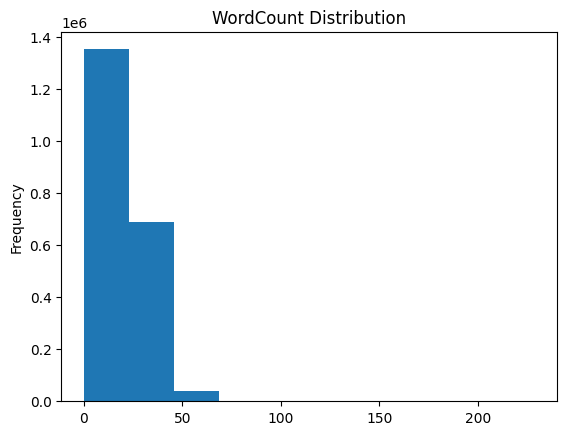

In [ ]:
train_df.WordCount.plot(kind='hist', title='WordCount Distribution');

## Target  (y) distribution of the first 64,000 sentences in the Training dataset

<Axes: ylabel='count'>

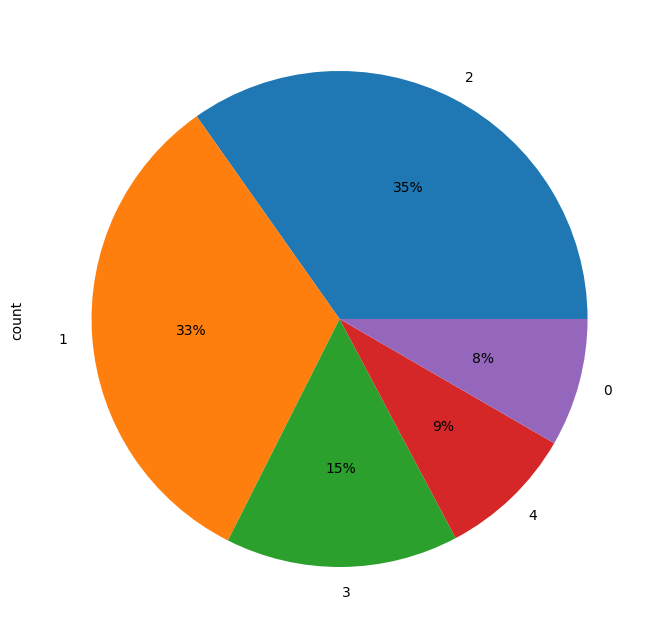

In [ ]:
plt.rcParams["figure.figsize"] = [8,10]
train_df[0:64000].y.value_counts().plot(kind='pie', autopct='%1.0f%%')

## Target (y) distribution in the Development dataset

<Axes: ylabel='count'>

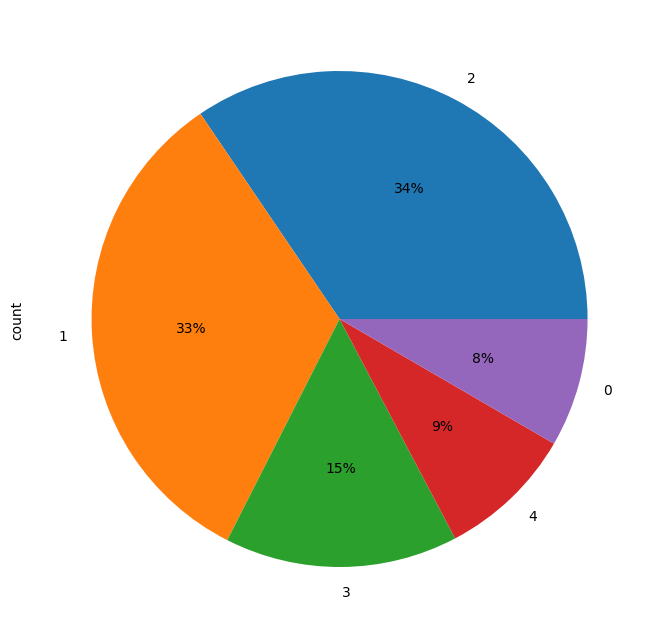

In [ ]:
plt.rcParams["figure.figsize"] = [8,10]
dev_df.y.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
import numpy as np

import tensorflow as tf
#import tensorflow_hub as hub
#import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
#print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.19.0
Eager mode:  True
GPU is available


## Install transformers package

In [ ]:
!pip install transformers==4.48.0

## Import BertTokenizer, BertConfig and TFBertForSequenceClassification from transformers

In [ ]:
from transformers import BertConfig
from transformers import (TFBertForSequenceClassification,
                          BertTokenizer)
from tqdm import tqdm

## training, validation(development) and test dataset

In [ ]:
X_train = train_df['X'].values
X_val = dev_df['X'].values
X_test = test_df['X'].values

y_train = train_df['y'].values
y_val = dev_df['y'].values
y_test = test_df['y'].values

# X_train_temp, , y_train_temp, y_test
# = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

print("Shape of training data: {0}, \nShape of test data: {1} \nShape of val data: {2}".format(X_train.shape, X_test.shape, X_val.shape))


Shape of training data: (2081790,), 
Shape of test data: (29493,) 
Shape of val data: (28932,)


## Create an object of the BertTokenizer class

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

## Convert texts to BERT input format

In [ ]:
max_length= 100
def text_to_bert_input(reviews):
    input_ids,attention_masks,token_type_ids=[],[],[]

    for review in tqdm(reviews, position=0, leave=True):
        #print(review)
        bert_inputs = bert_tokenizer(review,add_special_tokens=True,padding='max_length',
                                     max_length=max_length, truncation = True)

        input, mask, token_type = bert_inputs["input_ids"], bert_inputs["attention_mask"], bert_inputs["token_type_ids"]

        input_ids.append(input)
        attention_masks.append(mask)
        token_type_ids.append(token_type)



    return [np.asarray(input_ids),
            np.asarray(attention_masks),
            np.asarray(token_type_ids)]

In [ ]:
X_val.shape[0]

28932

In [ ]:
## taking partial samples of training dataset
## taking all samples of validation and test dataset

train_sample_size= 64000
val_sample_size= X_val.shape[0]
#test_sample_size= 3200

X_train_input=text_to_bert_input(X_train[0:train_sample_size])
X_val_input=text_to_bert_input(X_val[0:val_sample_size])
X_test_input=text_to_bert_input(X_test)

#### Taking whole samples
# X_test_input=text_to_bert_input(X_test)
# X_train_input=text_to_bert_input(X_train)
# X_val_input=text_to_bert_input(X_val)

##  Convert the input data into tensors

In [ ]:

def convert_to_tensors(input_ids,attention_masks,token_type_ids,y):


    return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y



In [ ]:
## taking partial samples of training dataset
## taking all samples of validation and test dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input[0],X_train_input[1],X_train_input[2],y_train[0:train_sample_size])).map(convert_to_tensors).shuffle(100).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input[0],X_test_input[1],X_test_input[2],y_test)).map(convert_to_tensors).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_input[0],X_val_input[1],X_val_input[2],y_val[0:val_sample_size])).map(convert_to_tensors).batch(32)


## taking whole samples y_train
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input[0],X_train_input[1],X_train_input[2],y_train)).map(convert_to_tensors).shuffle(100).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input[0],X_test_input[1],X_test_input[2],y_test)).map(convert_to_tensors).batch(32)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_input[0],X_val_input[1],X_val_input[2],y_val)).map(convert_to_tensors).batch(32)

## Fine-Tune BERT for Sequencial Sentence Classfication

In [ ]:
# Load pretrained model


num_labels = 5
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels)
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', config=config)

In [ ]:
## define Optimizer, Loss-function and Evaluation metric of the Model

opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=opt, loss=loss, metrics=[metric])
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108314117 (413.19 MB)
Trainable params: 108314117 (413.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
## Required to save models in HDF5 format

!pip install pyyaml h5py  # Required to save models in HDF5 format


In [ ]:
### Training model and saving the weights of the Best model

import time
start_time = time.time()

filepath ='/content/weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= filepath,
                                                         save_weights_only=True, save_best_only=True,verbose=1)
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks= [checkpoint_callback])

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/3
2000/2000 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8289
Epoch 1: val_loss improved from inf to 0.40274, saving model to /content/weights.h5
2000/2000 [==============================] - 1481s 707ms/step - loss: 0.4829 - accuracy: 0.8289 - val_loss: 0.4027 - val_accuracy: 0.8541
Epoch 2/3
2000/2000 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8759
Epoch 2: val_loss did not improve from 0.40274
2000/2000 [==============================] - 1399s 700ms/step - loss: 0.3460 - accuracy: 0.8759 - val_loss: 0.4198 - val_accuracy: 0.8536
Epoch 3/3
2000/2000 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.9019
Epoch 3: val_loss did not improve from 0.40274
2000/2000 [==============================] - 1398s 699ms/step - loss: 0.2727 - accuracy: 0.9019 - val_loss: 0.4973 - val_accuracy: 0.8386
--- 4278.901158332825 seconds ---


## Evaluate Model Performance on Test Dataset

#### Evaluate model performance on test dataset from the last epoch (epoch # 4)

In [ ]:
import time
start_time = time.time()

model.evaluate(test_dataset)

print("--- %s seconds ---" % (time.time() - start_time))

922/922 [==============================] - 200s 217ms/step - loss: 0.5157 - accuracy: 0.8365
--- 200.14222526550293 seconds ---


####  Evaluate model performance on the test dataset using the best saved model's weights

In [ ]:
### Load the saved weights (BEST Model)
model.load_weights('/content/weights.h5')


In [ ]:
import time
start_time = time.time()

model.evaluate(test_dataset)

print("--- %s seconds ---" % (time.time() - start_time))


922/922 [==============================] - 200s 217ms/step - loss: 0.4185 - accuracy: 0.8506
--- 199.86458468437195 seconds ---


#### Model predictions on Test dataset

In [ ]:
import time
start_time = time.time()

predictions = model.predict(test_dataset)

print("--- %s seconds ---" % (time.time() - start_time))


922/922 [==============================] - 201s 214ms/step
--- 201.28183603286743 seconds ---


In [ ]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[ 1.9417741 , -2.5651278 , -2.6445994 , -0.5796896 ,  2.792253  ],
       [ 2.0639226 , -2.4347587 , -2.527933  , -1.0431736 ,  2.8264537 ],
       [ 2.8098693 , -1.466419  , -2.9577587 , -1.9465253 ,  2.4385128 ],
       ...,
       [-3.3971975 ,  0.944037  ,  4.799721  ,  0.30720297, -2.3565092 ],
       [ 0.5461904 , -3.1467524 , -2.7766163 ,  2.971418  ,  1.7828195 ],
       [-2.407467  , -1.441293  ,  2.5936735 ,  3.2050161 , -1.3325288 ]],
      dtype=float32), hidden_states=None, attentions=None)

In [ ]:
y_pred = np.argmax(predictions.logits, axis=1)

In [ ]:
y_pred

array([4, 4, 0, ..., 2, 3, 3])

In [ ]:
y_test

array([4, 4, 4, ..., 2, 3, 3])

### Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[1585  118   15   74  585]
 [ 141 9036  447   67   60]
 [   9  567 9458  210   32]
 [   5   46  821 3231  323]
 [ 511  114   21  240 1777]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      2377
           1       0.91      0.93      0.92      9751
           2       0.88      0.92      0.90     10276
           3       0.85      0.73      0.78      4426
           4       0.64      0.67      0.65      2663

    accuracy                           0.85     29493
   macro avg       0.80      0.78      0.79     29493
weighted avg       0.85      0.85      0.85     29493

0.8506086189943376


### Confusion Matrix Heat Map

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
  # 'OBJECTIVE':0, 'METHODS':1, 'RESULTS':2, 'CONCLUSIONS':3, 'BACKGROUND':4

In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['OBJECTIVE','METHODS','RESULTS','CONCLUSIONS','BACKGROUND'],
                     columns = ['OBJECTIVE','METHODS','RESULTS','CONCLUSIONS','BACKGROUND'])

In [ ]:
cm_df

,OBJECTIVE,METHODS,RESULTS,CONCLUSIONS,BACKGROUND
OBJECTIVE,1585,118,15,74,585
METHODS,141,9036,447,67,60
RESULTS,9,567,9458,210,32
CONCLUSIONS,5,46,821,3231,323
BACKGROUND,511,114,21,240,1777


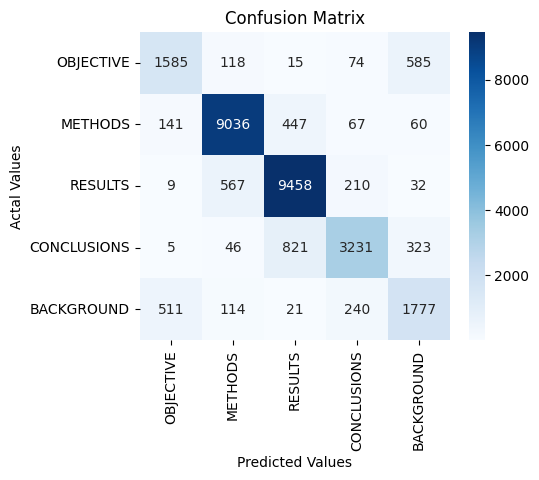

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()